<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Предыдущее-значение" data-toc-modified-id="Предыдущее-значение-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Предыдущее значение</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from catboost import CatBoostRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from scipy.stats import wilcoxon
from statsmodels.tsa.seasonal import seasonal_decompose
import os

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = 'datasets/taxi.csv'
pth3 = 'taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    print('Something is wrong')

In [4]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df['datetime'].duplicated().sum()

0

Пропуски и дубликаты отсутствуют.

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<AxesSubplot:xlabel='num_orders', ylabel='Density'>

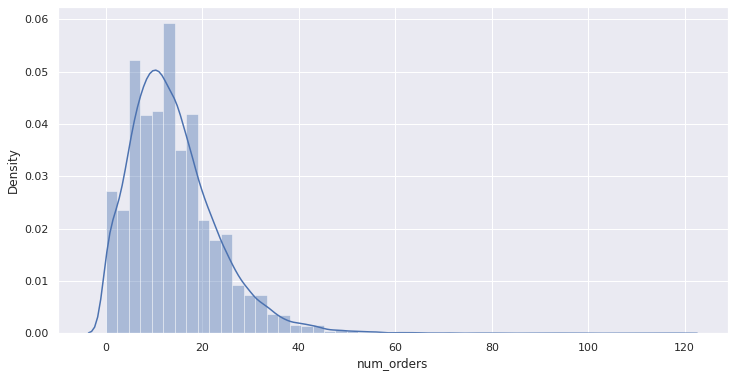

In [8]:
plt.figure(figsize=(12,6))
sns.distplot(df['num_orders'])

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [10]:
df = df.set_index('datetime')

In [11]:
df.sort_index(inplace=True)

In [12]:
# проверим на монотонность
print(df.index.is_monotonic)

True


In [13]:
df = df.resample('1H').sum()

In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


**Вывод** 

У нас есть данные заказов такси с марта по август 2018 года. Мы изменили тип данных Datetime с object на datetime64 и установили индекс таблицы равным столбцу Datetime. Проверили на наличие пропусков, на монотонность и ресемплировали данные по часу (изначально данные за каждые 10 минут).

## Анализ

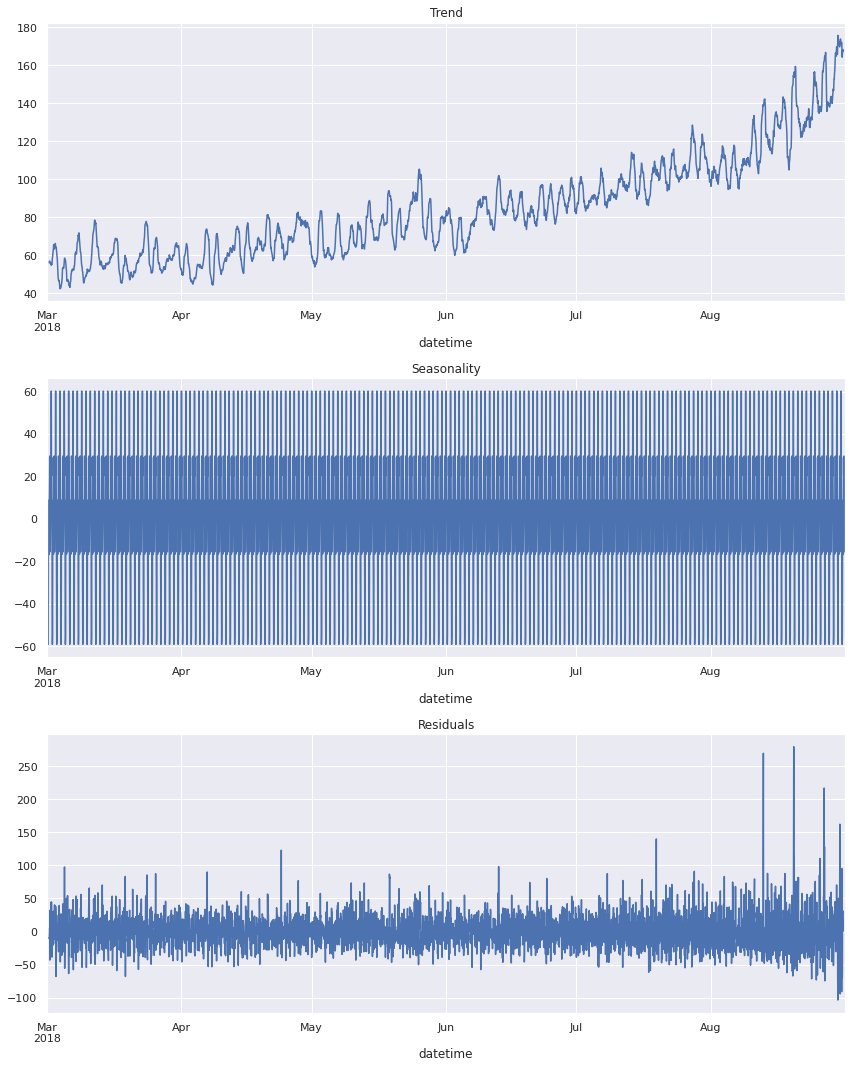

In [16]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca()) # trend
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # seasonality
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals') # residuals
plt.tight_layout()

Тренд растёт, стохастический процесс сезонности стационарный. За 2018-ый год тренд значительно увеличился.

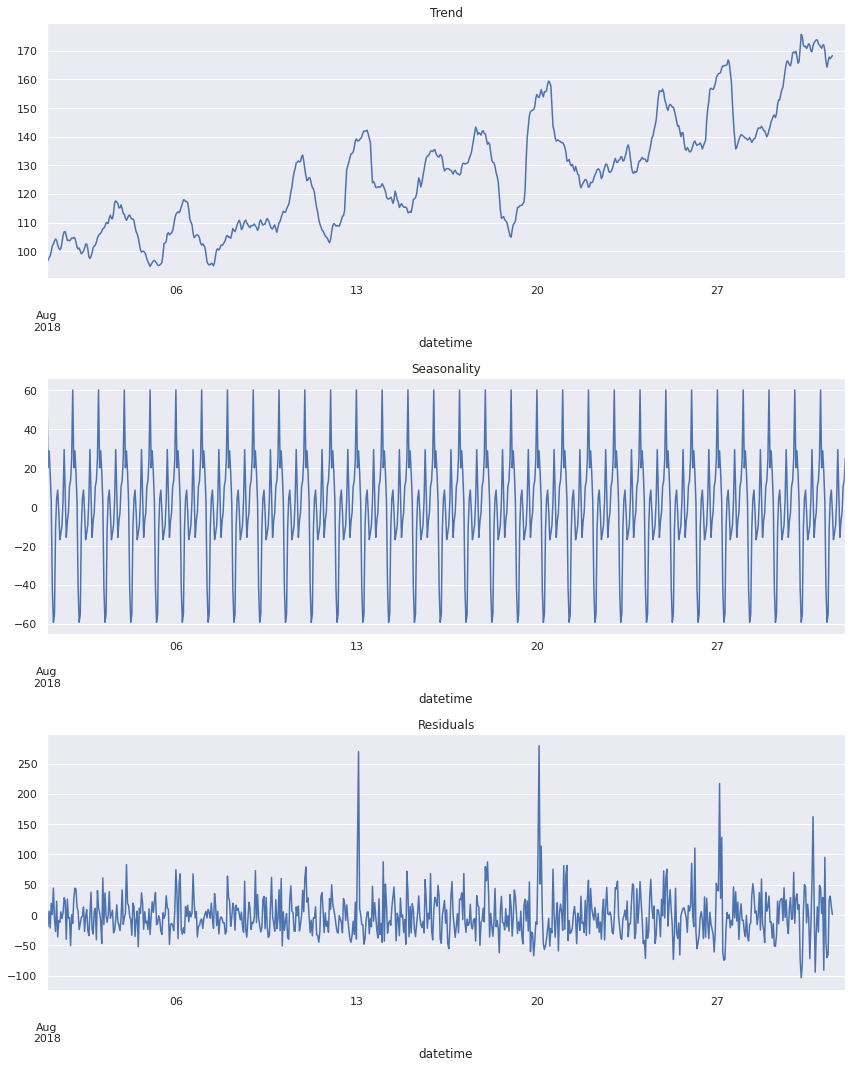

In [17]:
# Сделаем срез за август
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

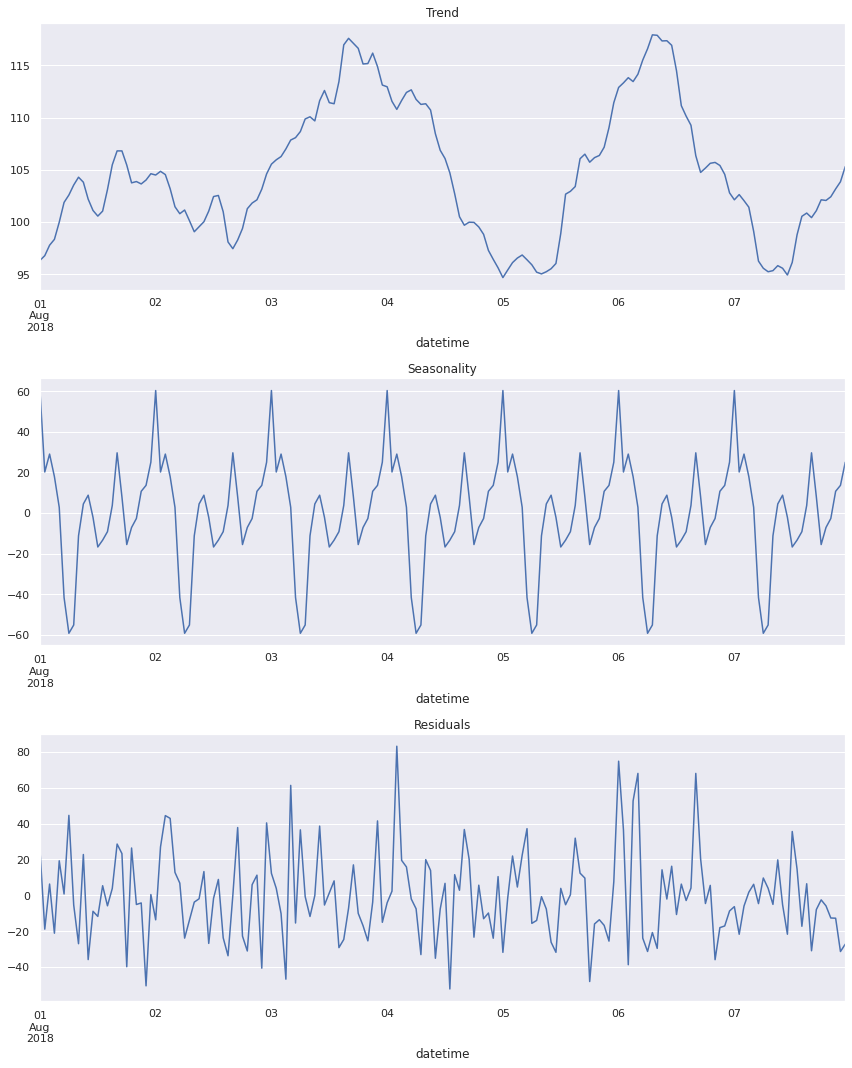

In [18]:
# Сделаем срез за неделю
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наибольшее количество заказов в пн, пт, сб.

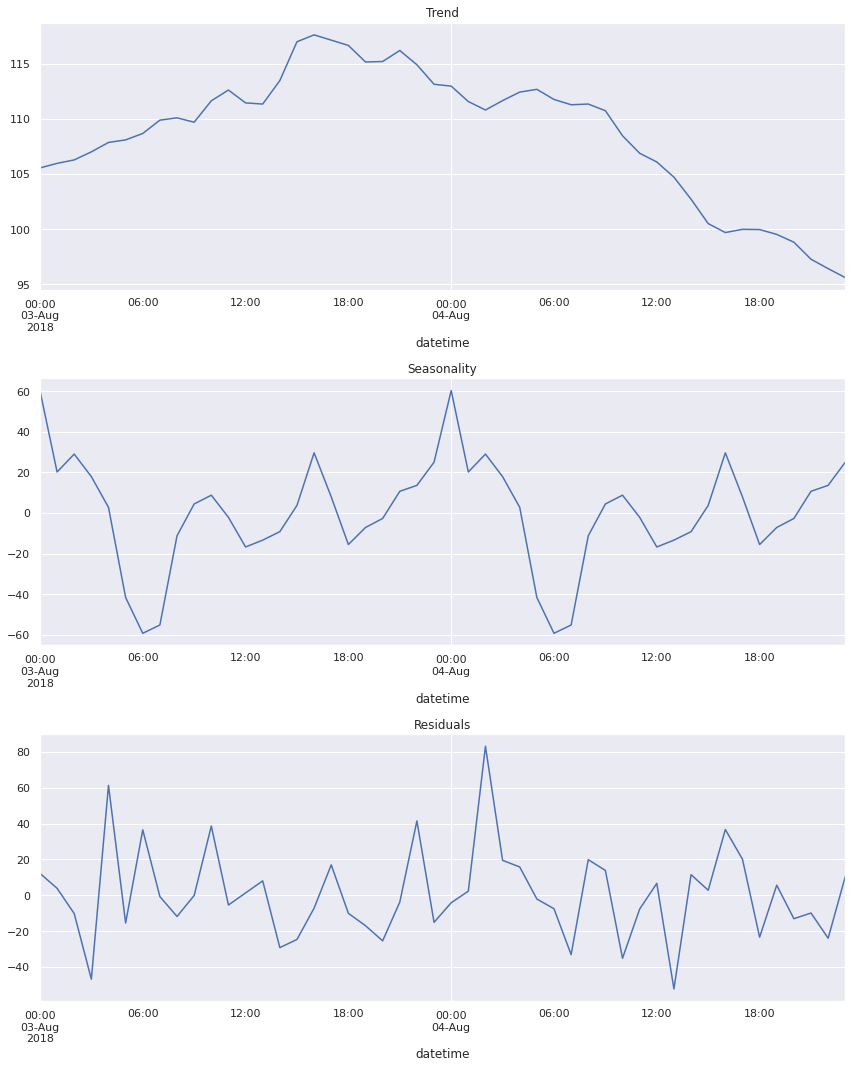

In [19]:
# Сделаем срез за пятницу и субботу
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-03':'2018-08-04'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-03':'2018-08-04'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-03':'2018-08-04'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

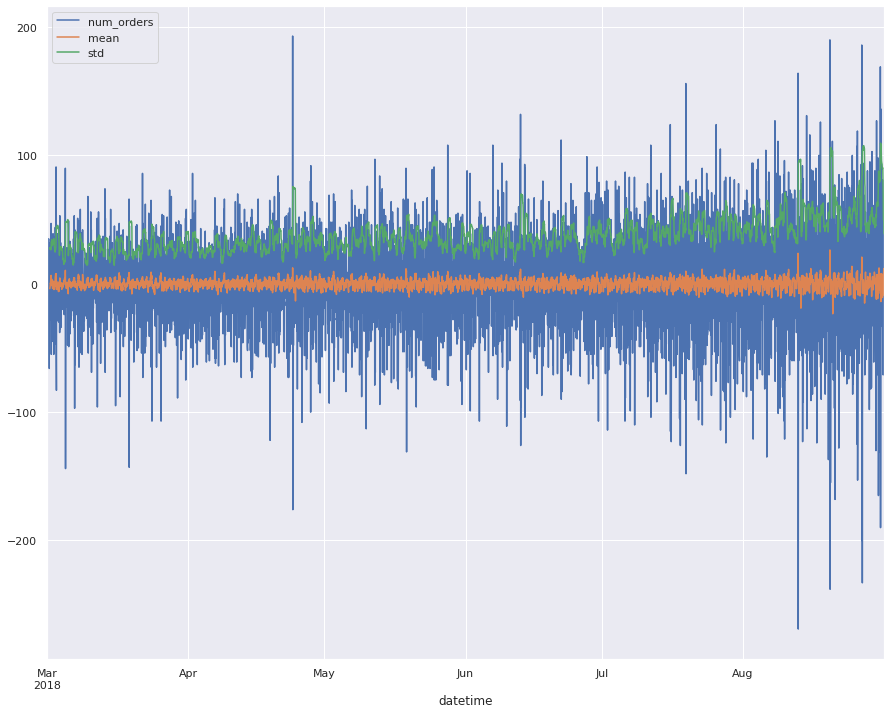

In [20]:
df1 = df - df.shift()
df1['mean'] = df1['num_orders'].rolling(15).mean()
df1['std'] = df1['num_orders'].rolling(15).std()
df1.plot(figsize=(15,12))
plt.show()

**Вывод**

За 2018-ый год тренд значительно увеличился. В рамках одного дня максимальное количество заказов достигается в вечернее время, минимальное - в утренние часы.

## Обучение

In [21]:
RANDOM_STATE = 11363
RANDOM_SEED = RANDOM_STATE

In [22]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

### Предыдущее значение

In [23]:
# Прогнозирование предыдущим значением

train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(f'Средний объём заказов такси в час: {train["num_orders"].mean():.2f}')

pred_previous = test.shift(fill_value=train['num_orders'].iloc[-1])
rmse = mean_squared_error(test['num_orders'], pred_previous['num_orders'])**0.5
print(f'RMSE предсказания предыдущим значением {rmse:.3f}')

Средний объём заказов такси в час: 78.29
RMSE предсказания предыдущим значением 58.856


In [24]:
results = pd.DataFrame(index = ['RMSE'])
results['1_"Previous"Model'] = [rmse]
results

,"1_""Previous""Model"
RMSE,58.856486


### Linear Regression

In [25]:
def make_features(max_lag, rolling_mean_size): # функция для создания фичей
    
    data_backup = df.copy()
    
    for lag in range(1, max_lag + 1):
        data_backup['lag_{}'.format(lag)] = data_backup['num_orders'].shift(lag)

    data_backup['rolling_mean'] = data_backup['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_backup

In [26]:
def preparation(max_lag, rolling_mean_size):
    
    df_prep = make_features(max_lag, rolling_mean_size)
    
    train, test = train_test_split(df_prep, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    X = df_prep.drop('num_orders', axis=1).columns
    y = ['num_orders']
    
    return train, test, X, y

In [27]:
lag_range = np.arange(12, 73, 12)
rolling_range = np.arange(5, 16, 5)

In [28]:
from tqdm import tqdm

In [29]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

In [30]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 10000

for max_lag in tqdm(lag_range):
    for rolling_mean_size in rolling_range:
        
        train, test, X, y = preparation(max_lag, rolling_mean_size)
        model = LinearRegression()
        model.fit(train[X], train[y])
        
        rmse = -cross_val_score(model, train[X], train[y], cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_rmse = rmse
       
print(f'Лучшие аргументы функции make_features для модели {model}:\nmax_lag = {best_max_lag}, rolling_mean_size = {best_rolling_mean_size}\nRMSE на CV {best_rmse:.3f}')

100%|██████████| 6/6 [00:21<00:00,  3.55s/it]

Лучшие аргументы функции make_features для модели LinearRegression():
max_lag = 36, rolling_mean_size = 15
RMSE на CV 26.599


In [31]:
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False]}
train, test, X, y = preparation(best_max_lag, best_rolling_mean_size)

gs_lr = GridSearchCV(LinearRegression(), param_grid=param_grid_lr, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
gs_lr.fit(train[X], train[y])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.3s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.8s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.2s
[CV 2/5] END ............fit_intercept=False, nor

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [32]:
print(f'Лучшие параметры модели {gs_lr.estimator} {gs_lr.best_params_}')
print(f'Лучший показатель RMSE на CV {-gs_lr.best_score_:.3f}')

Лучшие параметры модели LinearRegression() {'fit_intercept': True, 'normalize': False}
Лучший показатель RMSE на CV 26.599


In [33]:
results['2_LinearRegression'] = -gs_lr.best_score_
results

,"1_""Previous""Model",2_LinearRegression
RMSE,58.856486,26.599159


### Decision Tree

In [34]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 10000

for max_lag in tqdm(lag_range):
    for rolling_mean_size in rolling_range:
        
        train, test, X, y = preparation(max_lag, rolling_mean_size)
        model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        model.fit(train[X], train[y])
        
        rmse = -cross_val_score(model, train[X], train[y], cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_rmse = rmse
       
print(f'Лучшие аргументы функции make_features для модели {model}:\nmax_lag = {best_max_lag}, rolling_mean_size = {best_rolling_mean_size}\nRMSE на CV {best_rmse:.3f}')


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]

Лучшие аргументы функции make_features для модели DecisionTreeRegressor(random_state=11363):
max_lag = 12, rolling_mean_size = 10
RMSE на CV 33.872


In [35]:
param_grid_dt = {'max_depth':np.arange(2, 15)}
train, test, X, y = preparation(best_max_lag, best_rolling_mean_size)
gs_dt = GridSearchCV(model, param_grid=param_grid_dt, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
gs_dt.fit(train[X], train[y]);

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ....................................max_depth=2; total time=   0.0s
[CV 2/5] END ....................................max_depth=2; total time=   0.0s
[CV 3/5] END ....................................max_depth=2; total time=   0.0s
[CV 4/5] END ....................................max_depth=2; total time=   0.0s
[CV 5/5] END ....................................max_depth=2; total time=   0.0s
[CV 1/5] END ....................................max_depth=3; total time=   0.0s
[CV 2/5] END ....................................max_depth=3; total time=   0.0s
[CV 3/5] END ....................................max_depth=3; total time=   0.0s
[CV 4/5] END ....................................max_depth=3; total time=   0.0s
[CV 5/5] END ....................................max_depth=3; total time=   0.0s
[CV 1/5] END ....................................max_depth=4; total time=   0.0s
[CV 2/5] END ...................................

In [36]:
print(f'Лучшие параметры модели {gs_dt.estimator} {gs_dt.best_params_}')
print(f'Лучший показатель RMSE на CV {-gs_dt.best_score_:.3f}')

Лучшие параметры модели DecisionTreeRegressor(random_state=11363) {'max_depth': 7}
Лучший показатель RMSE на CV 30.348


In [37]:
results['3_DecisionTree'] = -gs_dt.best_score_
results

,"1_""Previous""Model",2_LinearRegression,3_DecisionTree
RMSE,58.856486,26.599159,30.347662


### RandomForest

In [38]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 10000

for max_lag in tqdm(lag_range):
    for rolling_mean_size in rolling_range:
        
        train, test, X, y = preparation(max_lag, rolling_mean_size)
        model = RandomForestRegressor(random_state=RANDOM_STATE)
        model.fit(train[X], train[y].values.ravel())
        
        rmse = -cross_val_score(model, train[X], train[y].values.ravel(), cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_rmse = rmse
       
print(f'Лучшие аргументы функции make_features для модели {model}:\nmax_lag = {best_max_lag}, rolling_mean_size = {best_rolling_mean_size}\nRMSE на CV {best_rmse:.3f}')

100%|██████████| 6/6 [09:02<00:00, 90.41s/it] 

Лучшие аргументы функции make_features для модели RandomForestRegressor(random_state=11363):
max_lag = 72, rolling_mean_size = 10
RMSE на CV 23.991


In [39]:
#param_grid_rf = {'max_depth':np.arange(2, 11, 2), 'n_estimators':np.arange(10, 100, 10)}
param_grid_rf = {'max_depth':[10], 'n_estimators':[60]}

train, test, X, y = preparation(best_max_lag, best_rolling_mean_size)

gs_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
gs_rf.fit(train[X], train[y].values.ravel());

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................max_depth=10, n_estimators=60; total time=   1.0s
[CV 2/5] END ..................max_depth=10, n_estimators=60; total time=   2.1s
[CV 3/5] END ..................max_depth=10, n_estimators=60; total time=   3.0s
[CV 4/5] END ..................max_depth=10, n_estimators=60; total time=   4.3s
[CV 5/5] END ..................max_depth=10, n_estimators=60; total time=   5.2s


In [40]:
print(f'Лучшие параметры модели {gs_rf.estimator} {gs_rf.best_params_}')
print(f'Лучший показатель RMSE на CV {-gs_rf.best_score_:.3f}')

Лучшие параметры модели RandomForestRegressor(random_state=11363) {'max_depth': 10, 'n_estimators': 60}
Лучший показатель RMSE на CV 24.106


In [41]:
results['4_RandomForest'] = -gs_rf.best_score_
results.style.format('{:.2f}')

,"1_""Previous""Model",2_LinearRegression,3_DecisionTree,4_RandomForest
RMSE,58.86,26.60,30.35,24.11


### CatBoost

In [42]:
params = {'loss_function': 'RMSE',
          'random_seed': RANDOM_SEED,
          'verbose': 0,
          'early_stopping_rounds': 100}

In [43]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 10000

for max_lag in tqdm(lag_range):
    for rolling_mean_size in rolling_range:
        
        train, test, X, y = preparation(max_lag, rolling_mean_size)
        model = CatBoostRegressor(**params)
        model.fit(train[X], train[y])
        
        rmse = -cross_val_score(model, train[X], train[y], cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_rmse = rmse
       
print(f'Лучшие аргументы функции make_features для модели CatBoostRegressor:\nmax_lag = {best_max_lag}, rolling_mean_size = {best_rolling_mean_size}\nRMSE на CV {best_rmse:.3f}')

100%|██████████| 6/6 [43:44<00:00, 437.37s/it]

Лучшие аргументы функции make_features для модели CatBoostRegressor:
max_lag = 72, rolling_mean_size = 10
RMSE на CV 23.117


In [44]:
model = CatBoostRegressor(**params)

In [45]:
param_grid_cb = {'depth': [4], 'l2_leaf_reg': [5], 'learning_rate': [0.1]}

train, test, X, y = preparation(best_max_lag, best_rolling_mean_size)

gs_cb = GridSearchCV(estimator=model, param_grid=param_grid_cb, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
gs_cb.fit(train[X], train[y]);

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  31.0s
[CV 2/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  15.7s
[CV 3/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  18.2s
[CV 4/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  19.3s
[CV 5/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  20.2s
[CV 1/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.3; total time=  14.5s
[CV 2/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.3; total time=  13.7s
[CV 3/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.3; total time=  29.4s
[CV 4/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.3; total time= 1.1min
[CV 5/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.3; total time=  18.7s
[CV 1/5] END ......depth=4, l2_leaf_reg=1, learning_rate=0.5; total time=  12.0s
[CV 2/5] END ......depth=4, l2_leaf_reg=1, learn

In [46]:
print(f'Лучшие параметры модели CatBoostRegressor {gs_cb.best_params_}')
print(f'Лучший показатель RMSE на CV {-gs_cb.best_score_:.3f}')

Лучшие параметры модели CatBoostRegressor {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Лучший показатель RMSE на CV 23.442


In [47]:
results['4_CatBoost'] = -gs_cb.best_score_
results

,"1_""Previous""Model",2_LinearRegression,3_DecisionTree,4_RandomForest,4_CatBoost
RMSE,58.856486,26.599159,30.347662,24.106333,23.441833


### LightGBM

In [ ]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 10000

for max_lag in tqdm(lag_range):
    for rolling_mean_size in tqdm(rolling_range):
        
        train, test, X, y = preparation(max_lag, rolling_mean_size)
        model = LGBMRegressor(random_state=RANDOM_STATE, verbose=0)
        model.fit(train[X], train[y])
        
        rmse = -cross_val_score(model, train[X], train[y], cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_rmse = rmse
       
print(f'Лучшие аргументы функции make_features для модели {model}:\nmax_lag = {best_max_lag}, rolling_mean_size = {best_rolling_mean_size}\nRMSE на CV {best_rmse:.3f}')

In [50]:
best_max_lag=72
best_rolling_mean_size=10

In [52]:
param_grid_lgbm = {'max_depth': [4],#, 8], 
                   'learning_rate': [0.1], #, 0.3, 0.5], 
                   'n_estimators': [100] #[10, 50, 100]
                   }

train, test, X, y = preparation(best_max_lag, best_rolling_mean_size)

gs_lgbm = GridSearchCV(estimator=model, param_grid=param_grid_lgbm, scoring='neg_root_mean_squared_error', cv=tscv, verbose=-1)
gs_lgbm.fit(train[X], train[y]);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [53]:
print(f'Лучшие параметры модели {gs_lgbm.estimator} {gs_lgbm.best_params_}')
print(f'Лучший показатель RMSE на CV {-gs_lgbm.best_score_:.3f}')

Лучшие параметры модели LGBMRegressor(random_state=11363, verbose=0) {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Лучший показатель RMSE на CV 23.681


In [54]:
results['4_LightGBM'] = -gs_lgbm.best_score_
results.T.style.format('{:.2f}', na_rep='-')

,RMSE
"1_""Previous""Model",58.86
2_LinearRegression,26.60
3_DecisionTree,30.35
4_RandomForest,24.11
4_CatBoost,23.44
4_LightGBM,23.68


**Вывод**

Лучший показатель RMSE на тренировочной выборке демонстрирует модель CatBoost, будем оценивать качество на тестовой выборке.

## Тестирование

In [56]:
model = CatBoostRegressor(**params, **gs_cb.best_params_)
train, test, X, y = preparation(72, 5) # Используем лучшие параметры
model.fit(train[X], train[y])
predictions_test = model.predict(test[X])
print(f'RMSE модели CatBoost {gs_cb.best_params_} на тестовой выборке\n{mean_squared_error(test[y], predictions_test)**0.5:.3f}')

RMSE модели CatBoost {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1} на тестовой выборке
39.514


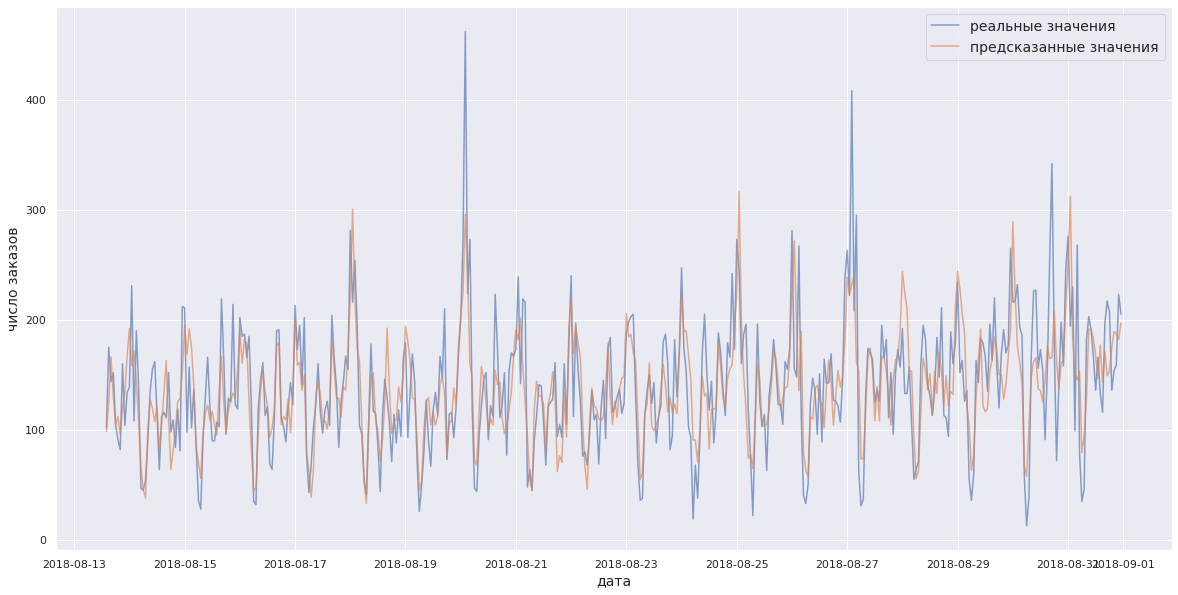

In [57]:
predictions_test = pd.Series(predictions_test, index=test[y].index)
plt.figure(figsize=(20,10))
plt.xlabel('дата', fontsize=14)
plt.ylabel('число заказов',fontsize=14)
plt.plot(test[y], label='реальные значения', alpha=0.65)
plt.plot(predictions_test, label='предсказанные значения', alpha=0.65)
plt.legend(fontsize=14)
plt.show()